# Baseball

In [55]:
import numpy
from scipy.interpolate import interp1d
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

### Simulating Baseball Flight

In [2]:
params = modsim.Params(
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    speed = 40,  # m / s

    mass = 145e-3,    # kg 
    diameter = 73e-3, # m 
    C_d = 0.33,       # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10,     # s
)

In [3]:
def make_system(params):
    
    # convert angle to degrees
    theta = numpy.deg2rad(params.angle)
    
    # compute x and y components of velocity
    vx, vy = modsim.pol2cart(theta, params.speed)
    
    # make the initial state
    init = modsim.State(x=params.x, y=params.y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = numpy.pi * (params.diameter/2)**2

    return modsim.System(params,
                         init = init,
                         area = area)

In [4]:
system = make_system(params)
system

namespace(x=0,
          y=1,
          angle=45,
          speed=40,
          mass=0.145,
          diameter=0.073,
          C_d=0.33,
          rho=1.2,
          g=9.8,
          t_end=10,
          init=x      0.000000
               y      1.000000
               vx    28.284271
               vy    28.284271
               Name: state, dtype: float64,
          area=0.004185386812745002)

In [5]:
def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * modsim.vector_mag(V)**2 * C_d * area / 2
    direction = - modsim.vector_hat(V)
    f_drag = mag * direction
    return f_drag

In [8]:
vx, vy = system.init.vx, system.init.vy
V_test = modsim.Vector(vx, vy)
f_drag = drag_force(V_test, system)
modsim.show(f_drag)

,component
x,-0.937574
y,-0.937574


In [9]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = modsim.Vector(vx, vy) # velocity
    
    a_drag = drag_force(V, system) / mass
    a_grav = g * modsim.Vector(0, -1)
    A = a_grav + a_drag # acceleration
    
    return V.x, V.y, A.x, A.y

In [10]:
slope_func(0, system.init, system)

(28.284271247461902, 28.2842712474619, -6.466030881564545, -16.266030881564546)

In [11]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

In [12]:
event_func(0, system.init, system)

1.0

In [13]:
results, details = modsim.run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

In [14]:
results.tail()

,x,y,vx,vy
4.804692,96.438515,4.284486e+00,14.590855,-20.726780
4.854740,97.166460,3.238415e+00,14.484772,-21.065476
4.904789,97.889087,2.175515e+00,14.378566,-21.400392
4.954838,98.606374,1.095978e+00,14.272264,-21.731499
5.004887,99.318296,7.105427e-15,14.165894,-22.058763


In [15]:
flight_time = results.index[-1]
flight_time

5.004887034868347

In [16]:
final_state = results.iloc[-1]
modsim.show(final_state)

,5.004887
x,9.931830e+01
y,7.105427e-15
vx,1.416589e+01
vy,-2.205876e+01


In [17]:
x_dist = final_state.x
x_dist

99.31829628352205

In [19]:
final_V = modsim.Vector(final_state.vx, final_state.vy)
modsim.show(final_V)

,component
x,14.165894
y,-22.058763


In [20]:
modsim.vector_mag(final_V)

26.21567445323758

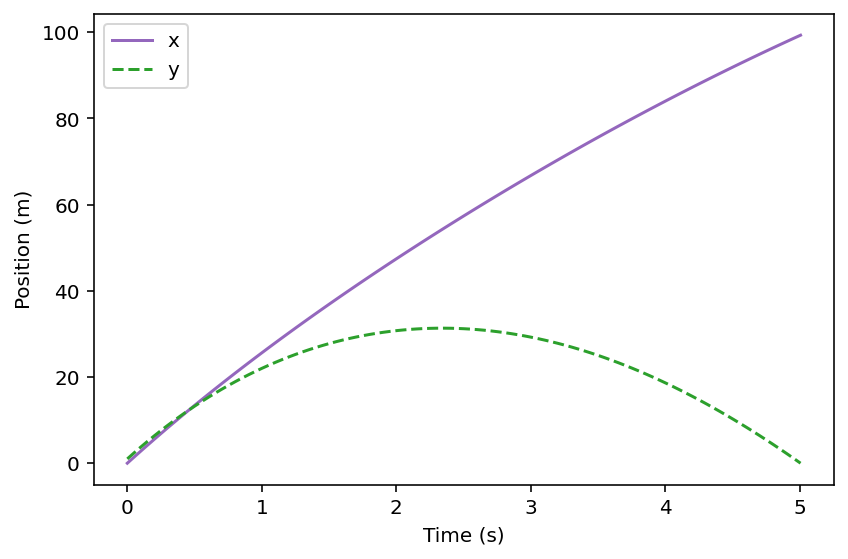

In [21]:
results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

modsim.decorate(xlabel='Time (s)',
         ylabel='Position (m)')

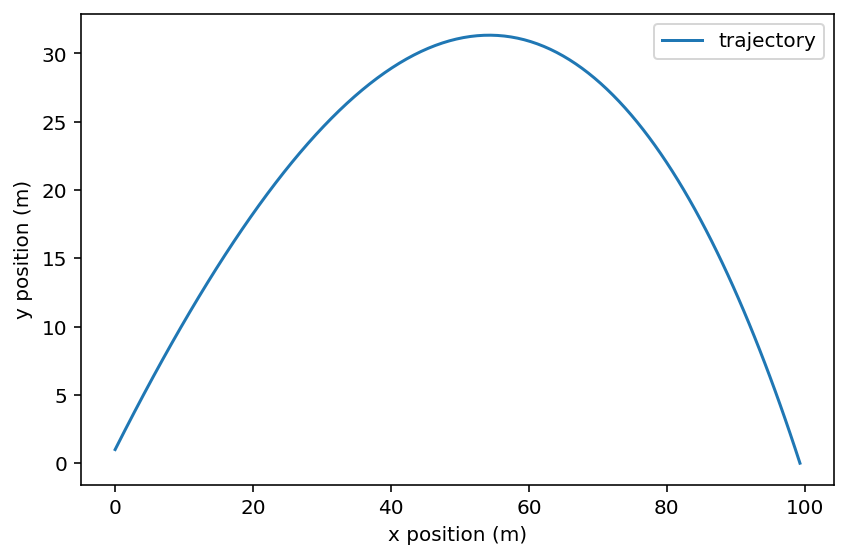

In [22]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    modsim.make_series(x, y).plot(label='trajectory')

    modsim.decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)

In [23]:
numpy.rad2deg(modsim.vector_angle(final_V))

-57.29187097821229

### Animating the Baseball

In [24]:
xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()

def draw_func(t, state):
    pyplot.plot(state.x, state.y, 'bo')
    modsim.decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

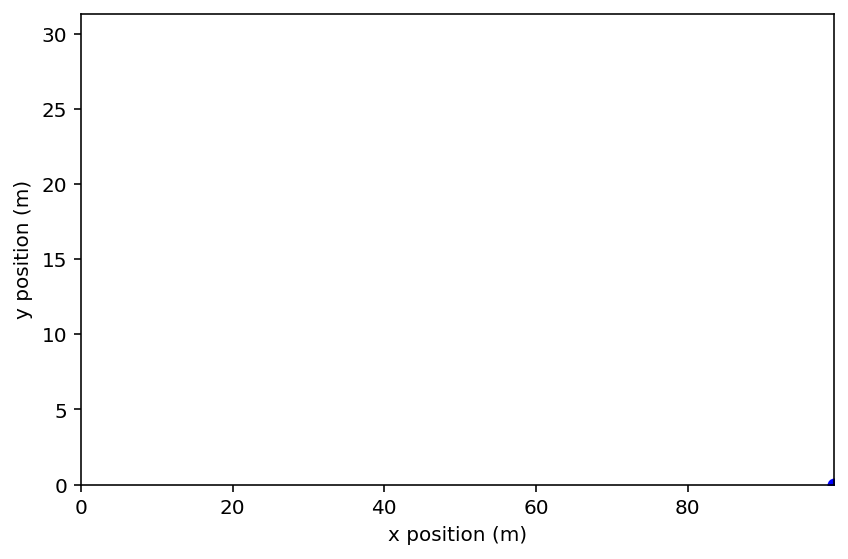

In [25]:
#modsim.animate(results, draw_func)

### Exercise 1
Run the simulation with and without air resistance. How wrong would we be if we ignored drag?

In [26]:
system_2 = make_system(params.set(C_d=0))
system_2

namespace(x=0,
          y=1,
          angle=45,
          speed=40,
          mass=0.145,
          diameter=0.073,
          C_d=0,
          rho=1.2,
          g=9.8,
          t_end=10,
          init=x      0.000000
               y      1.000000
               vx    28.284271
               vy    28.284271
               Name: state, dtype: float64,
          area=0.004185386812745002)

In [27]:
results_2, details_2 = modsim.run_solve_ivp(system_2, slope_func, events=event_func)
details_2.message

'A termination event occurred.'

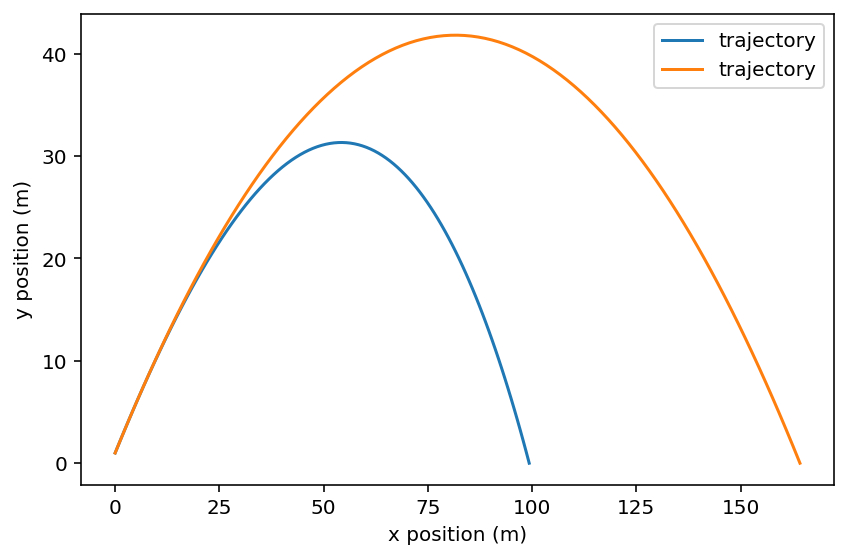

In [30]:
plot_trajectory(results)
plot_trajectory(results_2)

In [33]:
results_2.x.iloc[-1] - results.x.iloc[-1]

64.9409587406098

### Exercise 2
The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg/m^3. Compared with the example near sea level, how much farther would a ball travel if hit with the same initial speed and launch angle?

In [34]:
system3 = make_system(params.set(rho=1.0))
system3

namespace(x=0,
          y=1,
          angle=45,
          speed=40,
          mass=0.145,
          diameter=0.073,
          C_d=0.33,
          rho=1.0,
          g=9.8,
          t_end=10,
          init=x      0.000000
               y      1.000000
               vx    28.284271
               vy    28.284271
               Name: state, dtype: float64,
          area=0.004185386812745002)

In [35]:
results_3, details_3 = modsim.run_solve_ivp(system3, slope_func, events=event_func)
details_3.message

'A termination event occurred.'

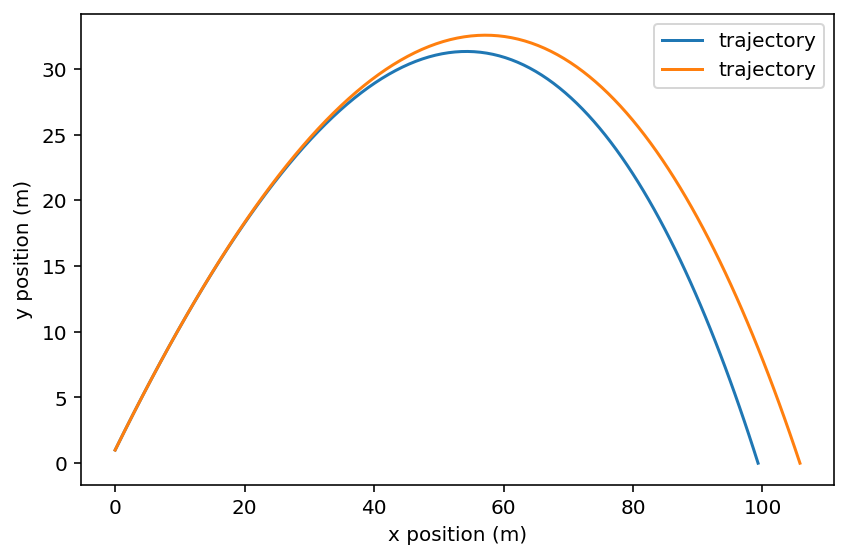

In [36]:
plot_trajectory(results)
plot_trajectory(results_3)

### Exercise 3
The model so far is based on the assumption that coefficient of drag does not depend on velocity, but in reality it does. The following figure, from Adair, The Physics of Baseball, shows coefficient of drag as a function of velocity (see https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC).

I used an online graph digitizer (https://automeris.io/WebPlotDigitizer) to extract the data and save it in a CSV file.

Modify the model to include the dependence of `C_d` on velocity, and see how much it affects the results.

In [125]:
def drag_force_3(V, system):
    rho, area = system.rho, system.area

    C_d = system.drag_interp(modsim.vector_mag(V))
    
    mag = rho * modsim.vector_mag(V)**2 * C_d * area / 2
    direction = - modsim.vector_hat(V)
    f_drag = mag * direction
    return f_drag

In [126]:
def slope_func_2(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = modsim.Vector(vx, vy) # velocity
    
    a_drag = drag_force_3(V, system) / mass
    a_grav = g * modsim.Vector(0, -1)
    A = a_grav + a_drag # acceleration
    
    return V.x, V.y, A.x, A.y

In [127]:
system_4 = make_system(params)
system_4

namespace(x=0,
          y=1,
          angle=45,
          speed=40,
          mass=0.145,
          diameter=0.073,
          C_d=0.33,
          rho=1.2,
          g=9.8,
          t_end=10,
          init=x      0.000000
               y      1.000000
               vx    28.284271
               vy    28.284271
               Name: state, dtype: float64,
          area=0.004185386812745002)

In [128]:
cd_velocity = pandas.read_csv("baseball_drag.csv")
cd_velocity["Velocity in mps"] = cd_velocity["Velocity in mph"]*0.44704
data_cd = pandas.DataFrame(
    {
        "C_d": cd_velocity["Drag coefficient"],
        "velocity": cd_velocity["Velocity in mps"],
    }
)
data_cd.head()

,C_d,velocity
0,0.49965,0.026146
1,0.49878,8.871509
2,0.49704,17.647351
3,0.48225,22.432914
4,0.45004,26.882303


<AxesSubplot:xlabel='velocity'>

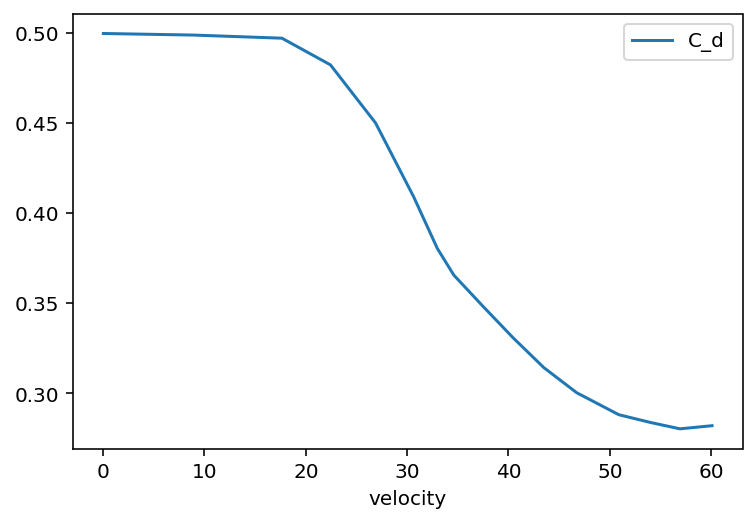

In [129]:
data_cd.plot(x="velocity", y="C_d")

In [130]:
system_4.drag_interp = interp1d(data_cd["velocity"], data_cd["C_d"], kind='linear')

In [131]:
results4, details4 = modsim.run_solve_ivp(system_4, slope_func_2, 
                                   events=event_func)
details4

  message: 'A termination event occurred.'
     nfev: 44
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x12911c2b0>
   status: 1
  success: True
 t_events: [array([4.91940706])]
 y_events: [array([[ 9.02066466e+01,  3.55271368e-15,  1.16404399e+01,
        -2.08372144e+01]])]

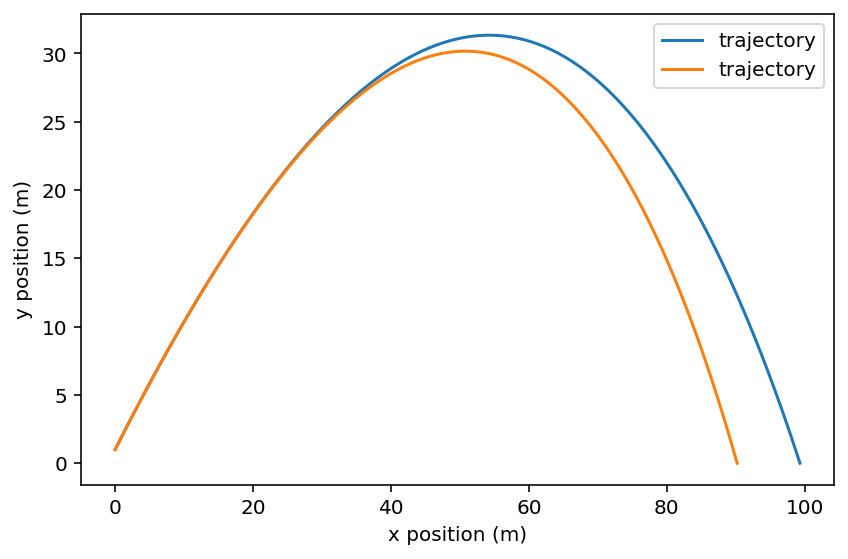

In [132]:
plot_trajectory(results)
plot_trajectory(results4)

In [133]:
results4.x.iloc[-1] - results.x.iloc[-1]

-9.111649717288941